In [1]:
import pandas, numpy
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
import torch
import warnings
import logging
from federated_learning import NeuralNet, load_train_data, Agent_Algorithm
from federated_learning.globals import LOAD_TRAIN_DATA_KWARGS, MODEL

'''
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=DeprecationWarning)
logging.disable(logging.INFO)
'''

C:\Users\windows 10\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


"\nwarnings.simplefilter(action='ignore', category=FutureWarning)\n#warnings.simplefilter(action='ignore', category=DeprecationWarning)\nlogging.disable(logging.INFO)\n"

## Pipeline_1
Data_Proprocessing

In [3]:
KDDTrain = pandas.read_csv(r'C:/Users/windows 10/Documents/FL/Dataset/KDDTrain+.csv',
                           names=['duration','protocol_type','service','flag','src_bytes','dst_bytes', 
                           'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in', 
                           'num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells', 
                           'num_acess_files','num_outbound_cmds','is_hot_login','is_guest_login','count','srv_count', 
                           'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate', 
                           'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
                           'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
                           'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
                           'dst_host_srv_rerror_rate','class','difficulty_level'])


KDDTest = pandas.read_csv(r'C:/Users/windows 10/Documents/FL/Dataset/KDDTest+.csv',
                          names=['duration','protocol_type','service','flag','src_bytes','dst_bytes', 
                          'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in', 
                          'num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells', 
                          'num_acess_files','num_outbound_cmds','is_hot_login','is_guest_login','count','srv_count', 
                          'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate', 
                          'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
                          'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
                          'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
                          'dst_host_srv_rerror_rate','class','difficulty_level'])



Dataset = pandas.concat([KDDTest, KDDTrain], ignore_index = True, axis = 0)

In [4]:
def updating_column(data:pandas.Series,
                    values:dict,
                    verify:bool=True,
                   ) -> pandas.DataFrame :
    """
    Updating a Serie_column with a given set of values.
    
    Parameters:
    data :  
        A series representing the column to be updated after.
        Note that, data won't be overwritten by-after.
        For better latency, the data shoud always be a single column, 
        even if the process will reoccure.
    
    values :
        Values of each data to replace. 
        A dictonary of { item : list, } 
        where each item represents the value desired after updating,
        followed by a corresponidng list of possible values to be replaced.
        
    verify :
        Default to True. 
        whether to check if all column values 
        are replaced with the corresponding ones.
        If not, a Warning will be raised. 
    
    Retruns: 
    pandas.Series column, with values bein updated
    
    """
    
    mapping = {
        old: new
        for new, olds in values.items() 
        for old in olds
    }
    
    column = data.apply(lambda x: mapping.get(x,x))
    
    try :
        if verify and not all(column.isin(values.keys())) :
            raise UserWarning("<!> Not all values are matched. "
                              "Existing of values other than indicated. ")
    
    except UserWarning :
        pass
    
    return column

terms = {'Normal':['normal'],
         'DoS':['apache2','back','land',
                'neptune','mailbomb','pod',
                'processtable','smurf','teardrop',
                'udpstorm','worm'],
         'Probe':['ipsweep','mscan','nmap',
                  'portsweep','saint','satan'],
         'U2R':['buffer_overflow','loadmodule',
                'perl','ps','rootkit','sqlattack',
                'xterm'],
         'R2L':['ftp_write','guess_passwd','httptunnel',
                  'imap','multihop','named','phf','sendmail',
                  'snmpgetattack','spy','snmpguess',
                  'warezclient','warezmaster','xlock','xsnoop']
        }

Dataset['class'] = updating_column(Dataset['class'], terms) # drop = True

In [5]:
# Splitting our dataset into continuous, binary and categorical columns
X_continuous = pandas.DataFrame(Dataset, columns=['duration','src_bytes','dst_bytes',
                                             'hot','num_failed_logins','num_compromised',
                                             'num_root','num_file_creations','num_shells',
                                             'num_acess_files','num_outbound_cmds','count','srv_count', 
                                             'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
                                             'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
                                             'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
                                             'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
                                             'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
                                             'dst_host_srv_rerror_rate'])

X_discrete = pandas.DataFrame(Dataset, columns=['land','wrong_fragment','urgent','logged_in','root_shell',
                                           'su_attempted','is_hot_login','is_guest_login'])

X_categorical = pandas.DataFrame(Dataset, columns=['protocol_type','service','flag'])

y = Dataset[['class']]


# Encoding categorical columns into numerical columns
F_encoder = OneHotEncoder(sparse_output=False)
X_categorical = F_encoder.fit_transform(X_categorical)
# We have to preserve our data as a Dataframe_type instance
X_categorical = pandas.DataFrame(X_categorical, columns = F_encoder.get_feature_names_out())

T_encoder = OneHotEncoder(sparse_output=False)
y = T_encoder.fit_transform(y)
y = pandas.DataFrame(y, columns = T_encoder.get_feature_names_out())

# Scaling continuous columns to avoid saturation
R_scaler = RobustScaler()
X_continuous = R_scaler.fit_transform(X_continuous)

# We have to preserve our data as a Dataframe_type instance
X_continuous = pandas.DataFrame(X_continuous, columns=R_scaler.feature_names_in_)

# Assembling our columns onto X
X = pandas.concat([X_continuous, X_discrete, X_categorical], axis=1)

## Pipeline_2
Federated_Learning

In [6]:
client_id = 1

distribution= {(0, 0, 0, 0, 1): 0,
                (0, 0, 0, 1, 0): 1,
                (0, 0, 1, 0, 0): 0,
                (0, 1, 0, 0, 0): 0,
                (1, 0, 0, 0, 0): 1}

In [7]:
train_loader, valid_loader = load_train_data(data = (X, y),
                                      size = 1.,
                                      valid_rate = .45,
                                      batch_size = 1024,
                                      distribution = None,
                                      sparse_y = True
                                     )

In [8]:
from federated_learning.client import Agent_Algorithm

In [9]:
alg = Agent_Algorithm(client_id=1, train_loader=train_loader, valid_loader=valid_loader, distribution=None, epochs=5)


Starting communication...
Fit, config: {}

Round: 1
Training >> Epoch: 1 | Loss: 0.0017 | Accuracy: 0.0385
Training >> Epoch: 2 | Loss: 0.0016 | Accuracy: 0.4740
Training >> Epoch: 3 | Loss: 0.0040 | Accuracy: 0.5135
Training >> Epoch: 4 | Loss: 0.0013 | Accuracy: 0.5236
Training >> Epoch: 5 | Loss: 0.0013 | Accuracy: 0.5248


C:\Users\windows 10\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Evaluate, config: {}
Evaluation >> Loss: 0.0012 | Accuracy: 0.5186
None
Fit, config: {}

Round: 2
Training >> Epoch: 1 | Loss: 0.0012 | Accuracy: 0.5248
Training >> Epoch: 2 | Loss: 0.0011 | Accuracy: 0.5291
Training >> Epoch: 3 | Loss: 0.0011 | Accuracy: 0.5303
Training >> Epoch: 4 | Loss: 0.0011 | Accuracy: 0.5303
Training >> Epoch: 5 | Loss: 0.0010 | Accuracy: 0.5354
Evaluate, config: {}
Evaluation >> Loss: 0.0010 | Accuracy: 0.5400
None
Fit, config: {}

Round: 3
Training >> Epoch: 1 | Loss: 0.0010 | Accuracy: 0.5448
Training >> Epoch: 2 | Loss: 0.0010 | Accuracy: 0.5603
Training >> Epoch: 3 | Loss: 0.0009 | Accuracy: 0.7069
Training >> Epoch: 4 | Loss: 0.0010 | Accuracy: 0.7738
Training >> Epoch: 5 | Loss: 0.0009 | Accuracy: 0.8174
Evaluate, config: {}
Evaluation >> Loss: 0.0009 | Accuracy: 0.8279
None
Ending communication...



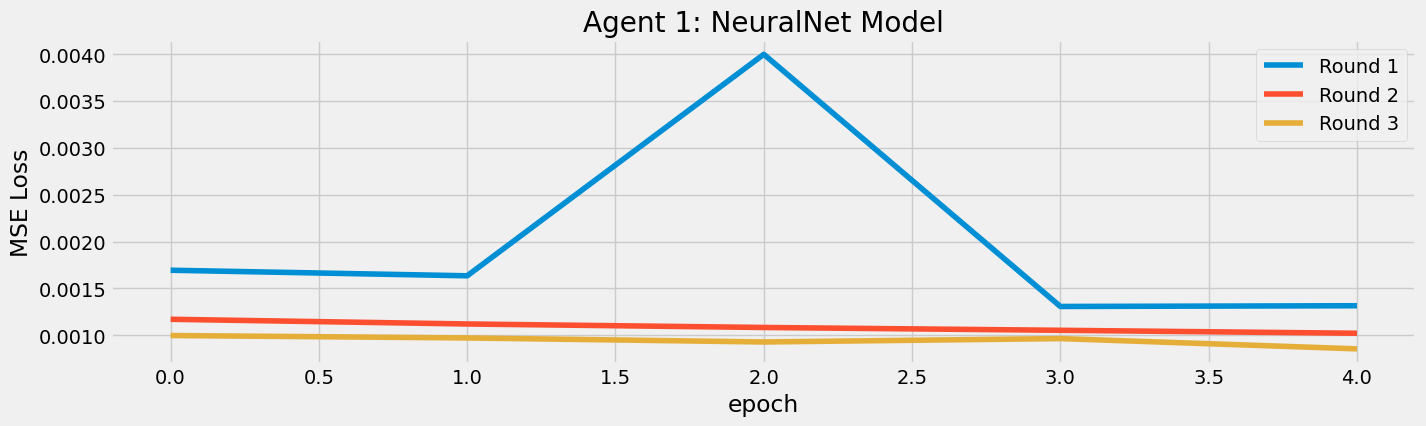

In [10]:
alg(server_address = '127.0.0.1', port = 1234)